In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/552_crop6.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/267_crop16.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/50_crop12.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/405_crop11.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/598_crop9.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/435_crop2.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/435_crop14.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/373_crop8.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/175_crop13.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/107_crop6.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/72_crop15.png
/kaggle/input/cropped-final-kymograms/f

In [4]:
from sklearn.model_selection import train_test_split
import os, shutil
from pathlib import Path
from collections import defaultdict

src_dir = Path("/kaggle/input/cropped-final-kymograms/final kymograms cropped")
dst_dir = Path("/kaggle/working/tertiary_split")

# Step 1: Gather all images with their class labels
all_images = []
class_map = defaultdict(list)

for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    images = list(cls_dir.glob("*.png"))
    for img in images:
        all_images.append((img, cls))  # Store path and class label
        class_map[cls].append(img)

# Step 2: Global split - 15% test
trainval, test = train_test_split(all_images, test_size=0.15, random_state=42, stratify=[label for _, label in all_images])

# Step 3: Split remaining into 70% train, 30% val
train, val = train_test_split(trainval, test_size=0.15, random_state=42, stratify=[label for _, label in trainval])

# Step 4: Copy images to appropriate folders
def copy_images(split_name, data):
    for img_path, cls in data:
        split_dir = dst_dir / split_name / cls
        split_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, split_dir / img_path.name)

copy_images("train", train)
copy_images("val", val)
copy_images("test", test)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "/kaggle/working/tertiary_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "/kaggle/working/tertiary_split/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


2025-05-08 22:17:52.755290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746742673.205251      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746742673.348152      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 7149 images belonging to 3 classes.
Found 1262 images belonging to 3 classes.


In [6]:
import random
import shutil
from pathlib import Path

train_dir = Path("/kaggle/working/tertiary_split/train")

# Step 1: Count images in each class
class_counts = {}
for cls_folder in train_dir.iterdir():
    if cls_folder.is_dir():
        class_counts[cls_folder.name] = len(list(cls_folder.glob("*.png")))

# Step 2: Find maximum class count
max_count = max(class_counts.values())

# Step 3: Oversample each class to match max_count
for cls_name, count in class_counts.items():
    cls_path = train_dir / cls_name
    images = list(cls_path.glob("*.png"))
    
    if count < max_count:
        needed = max_count - count
        to_duplicate = random.choices(images, k=needed)  # Randomly pick with replacement

        for i, img in enumerate(to_duplicate):
            # Create new filename to avoid overwriting
            new_name = cls_path / f"{img.stem}_dup{i}{img.suffix}"
            shutil.copy(img, new_name)

print("✅ Training set balanced by oversampling.")


✅ Training set balanced by oversampling.


Found 13479 images belonging to 3 classes.
Found 1262 images belonging to 3 classes.
Found 1485 images belonging to 3 classes.


I0000 00:00:1746742694.766489      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746742694.767258      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 11,891,779 (45.36 MB)

 Trainable params: 4,852,739 (18.51 MB)

 Non-trainable params: 7,039,040 (26.85 MB)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746742724.264561     137 service.cc:148] XLA service 0x7bf1e4023070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746742724.266247     137 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746742724.266269     137 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746742727.318358     137 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/422 ━━━━━━━━━━━━━━━━━━━━ 4:42:02 40s/step - accuracy: 0.3125 - loss: 1.7359

I0000 00:00:1746742740.652472     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 223s 435ms/step - accuracy: 0.6340 - loss: 0.8971 - val_accuracy: 0.8605 - val_loss: 0.3402
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 153s 356ms/step - accuracy: 0.8585 - loss: 0.3543 - val_accuracy: 0.8281 - val_loss: 0.4380
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 150s 351ms/step - accuracy: 0.8972 - loss: 0.2678 - val_accuracy: 0.9160 - val_loss: 0.2332
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 153s 357ms/step - accuracy: 0.9287 - loss: 0.1994 - val_accuracy: 0.9319 - val_loss: 0.1790
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 152s 355ms/step - accuracy: 0.9373 - loss: 0.1745 - val_accuracy: 0.9017 - val_loss: 0.2352
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 153s 356ms/step - accuracy: 0.9467 - loss: 0.1524 - val_accuracy: 0.9382 - val_loss: 0.1819
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 154s 359ms/step - accuracy: 0.9484 - loss: 0.1429 - val_accuracy: 0.9231 - val_loss: 0.2088
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 152s 354ms/step - accuracy: 0.9512 - loss: 0.13

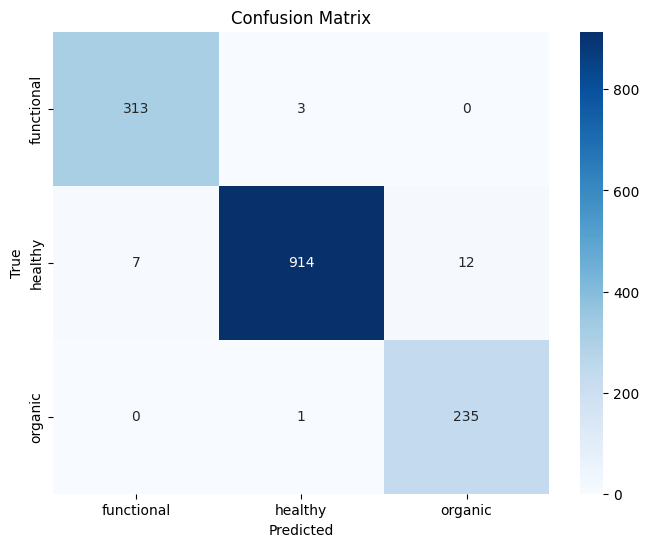

Classification Report:
              precision    recall  f1-score   support

  functional       0.98      0.99      0.98       316
     healthy       1.00      0.98      0.99       933
     organic       0.95      1.00      0.97       236

    accuracy                           0.98      1485
   macro avg       0.98      0.99      0.98      1485
weighted avg       0.98      0.98      0.98      1485



In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, ReLU, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
train_dir = "/kaggle/working/tertiary_split/train"
val_dir = "/kaggle/working/tertiary_split/val"
test_dir = "/kaggle/working/tertiary_split/test"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
img_size = (224, 224)
batch_size = 32

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Model (DenseNet121)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Custom layers
x = base_model.output
x = MaxPooling2D(pool_size=(2, 2))(x)  # Adding MaxPooling
x = Flatten()(x)  # Flattening the output for the fully connected layers
x = Dense(512)(x)  # Dense layer with 512 units
x = ReLU()(x)  # ReLU activation
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.25)(x)  # Dropout for regularization
x = Dense(256)(x)  # Dense layer with 256 units
x = ReLU()(x)  # ReLU activation
x = BatchNormalization()(x)  # Batch Normalization
output = Dense(3, activation='softmax')(x)  # Output layer with 3 classes

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks
callbacks = [
    ModelCheckpoint("best_model_densenet.keras", save_best_only=True),
]

# Training the model
history = model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks)

# Load Best Model
model = tf.keras.models.load_model("best_model_densenet.keras")

# Evaluation
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize

# Load Best Model
model = tf.keras.models.load_model("best_model_densenet.keras")

# Evaluation
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = list(test_gen.class_indices.keys())

# Binarize true labels for AUC and sensitivity/specificity
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred)

# Compute metrics
auc_scores = roc_auc_score(y_true_bin, y_pred_probs, average=None)

# Sensitivity (Recall) & Specificity
sensitivity = []
specificity = []

for i in range(len(class_names)):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)
    
    sensitivity.append(TP / (TP + FN) * 100 if (TP + FN) > 0 else 0)
    specificity.append(TN / (TN + FP) * 100 if (TN + FP) > 0 else 0)

# Accuracy
acc = accuracy_score(y_true, y_pred) * 100

# Print nicely formatted report
print("\nTest Performance of Tertiary Classification")
print(f"{'Metrics':<15}{'DenseNet121':>12}")
print("-" * 30)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'AUC (%)':<15}{auc_scores[i]*100:>12.2f}")
    print(f"{'F1 score (%)':<15}{report[cls]['f1-score']*100:>12.2f}")
    print(f"{'Precision (%)':<15}{report[cls]['precision']*100:>12.2f}")
    print(f"{'Recall (%)':<15}{report[cls]['recall']*100:>12.2f}")
    print(f"{'Sensitivity (%)':<15}{sensitivity[i]:>12.2f}")
    print(f"{'Specificity (%)':<15}{specificity[i]:>12.2f}")
    print("-" * 30)

print(f"{'Overall Accuracy (%)':<20}{acc:.2f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 310ms/step

Test Performance of Tertiary Classification
Metrics         DenseNet121
------------------------------
functional
AUC (%)               99.98
F1 score (%)          98.43
Precision (%)         97.81
Recall (%)            99.05
Sensitivity (%)       99.05
Specificity (%)       99.40
------------------------------
healthy
AUC (%)               99.95
F1 score (%)          98.76
Precision (%)         99.56
Recall (%)            97.96
Sensitivity (%)       97.96
Specificity (%)       99.28
------------------------------
organic
AUC (%)               99.97
F1 score (%)          97.31
Precision (%)         95.14
Recall (%)            99.58
Sensitivity (%)       99.58
Specificity (%)       99.04
------------------------------
Overall Accuracy (%)98.45


Found 1262 images belonging to 3 classes.
 2/40 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step
Validation class mapping: {'functional': 0, 'healthy': 1, 'organic': 2}

Validation Performance of Tertiary Classification
Metrics              DenseNet121
------------------------------
functional
F1 score (%)         97.45
Precision (%)        95.36
Recall (%)           99.63
------------------------------
healthy
F1 score (%)         98.54
Precision (%)        99.49
Recall (%)           97.60
------------------------------
organic
F1 score (%)         97.28
Precision (%)        96.57
Recall (%)           98.01
------------------------------
Accuracy (%)         98.10


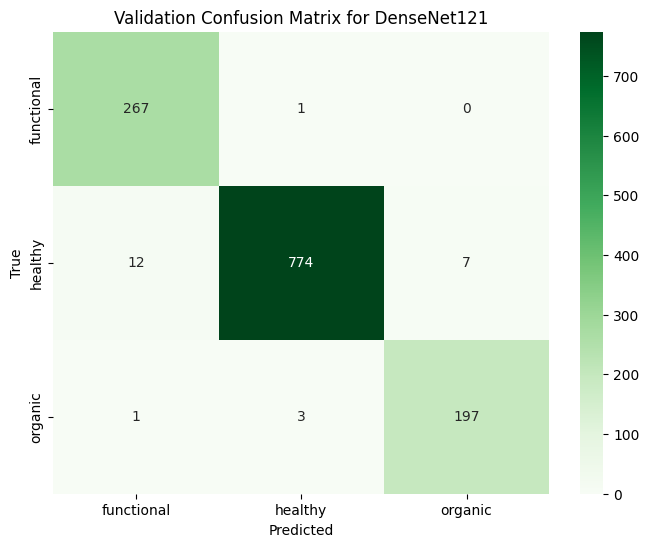

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set shuffle=False for validation generator if not already
val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

# Predict on validation set
val_true = val_gen.classes
val_pred_probs = model.predict(val_gen)
val_pred = np.argmax(val_pred_probs, axis=1)

# Class labels
val_labels = list(val_gen.class_indices.keys())

# Check class index mapping
print("Validation class mapping:", val_gen.class_indices)

# Classification Report
val_report = classification_report(val_true, val_pred, target_names=val_labels, output_dict=True)
val_acc = accuracy_score(val_true, val_pred) * 100

# Confusion Matrix
cm_val = confusion_matrix(val_true, val_pred)

# Print Report (Formatted like your table)
print("\nValidation Performance of Tertiary Classification")
print(f"{'Metrics':<20} {'DenseNet121'}")
print("-" * 30)

for class_name in val_labels:
    print(f"{class_name.lower()}")
    print(f"{'F1 score (%)':<20} {val_report[class_name]['f1-score'] * 100:.2f}")
    print(f"{'Precision (%)':<20} {val_report[class_name]['precision'] * 100:.2f}")
    print(f"{'Recall (%)':<20} {val_report[class_name]['recall'] * 100:.2f}")
    print("-" * 30)

print(f"{'Accuracy (%)':<20} {val_acc:.2f}")

# Optional: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Greens", xticklabels=val_labels, yticklabels=val_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix for DenseNet121")
plt.show()


In [10]:
# Create a feature extractor model from the base DenseNet
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Re-initialize test generator without class labels (class_mode=None) and no shuffling
feature_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode=None, shuffle=False
)

# Extract features from the test images
features = feature_extractor.predict(feature_gen, verbose=1)  # Shape: (num_images, H, W, C)

# Flatten features to 2D (e.g., for ML models or saving as CSV)
features_flat = features.reshape((features.shape[0], -1))  # Shape: (num_images, feature_dim)

# Save to .npy file
np.save("/kaggle/working/densenet121_features.npy", features_flat)

# Optionally, save as CSV if needed
import pandas as pd
df_features = pd.DataFrame(features_flat)
df_features.to_csv("/kaggle/working/densenet121_features.csv", index=False)

print("Feature vectors saved as 'densenet121_features.npy' and 'densenet121_features.csv'")


Found 1485 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 314ms/step
Feature vectors saved as 'densenet121_features.npy' and 'densenet121_features.csv'


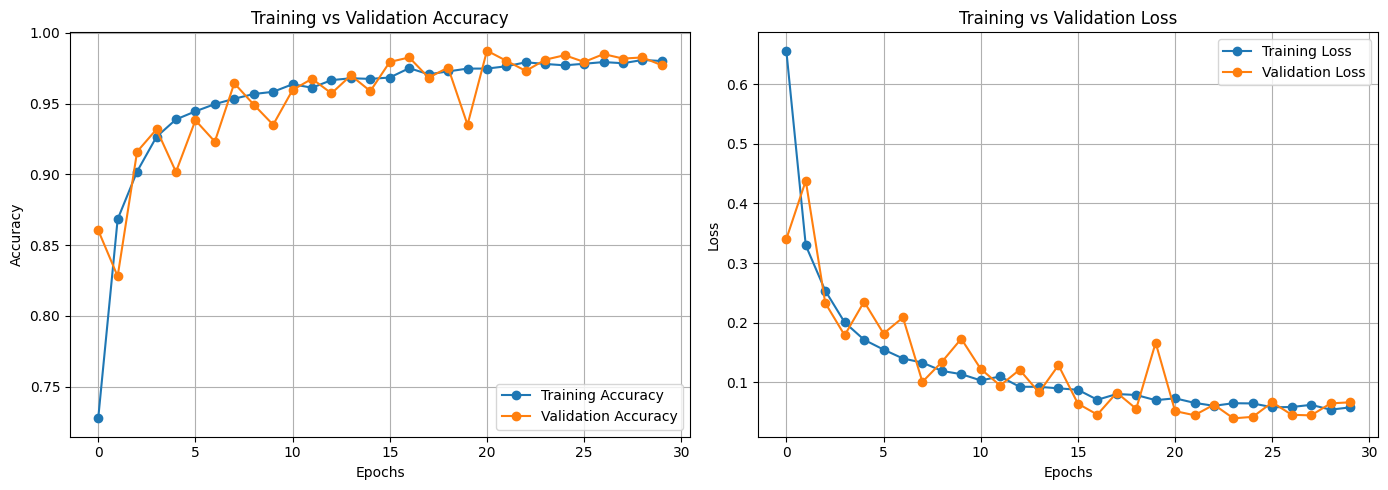

In [11]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Save accuracy and loss values to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv("accuracy_loss_perdensenet tertiary_epoch.csv", index=False)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC curve (One-hot encode true labels)
n_classes = 3
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Save ROC values to CSV
roc_data = []

for i in range(n_classes):
    for fp, tp in zip(fpr[i], tpr[i]):
        roc_data.append({"class": labels[i], "fpr": fp, "tpr": tp, "auc": roc_auc[i]})

# Micro average
for fp, tp in zip(fpr["micro"], tpr["micro"]):
    roc_data.append({"class": "micro", "fpr": fp, "tpr": tp, "auc": roc_auc["micro"]})

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv("roc_valuesdensenettertiary.csv", index=False)
